In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from torch.autograd import Variable
import torch.nn.functional as F

import gym
import cv2
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from rq import Queue
from redis import Redis

import imageio
import random
import sys
import os
import time
import pickle
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ga_model import *

def to_np(x):
    return x.data.cpu().numpy()

# Gym stuff

In [2]:
env = gym.make('SpaceInvadersDeterministic-v4')

Discrete(6)


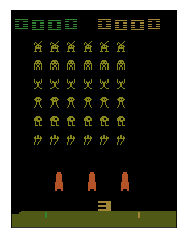

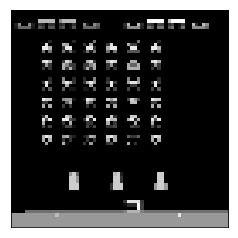

In [3]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    if len(im.shape) == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def render(env, converted=False):
    state = env.render(mode='rgb_array')
    if converted:
        state = convert_state(state)
    plt.show(show_img(state))
    
reset(env)
print(env.action_space)
render(env)
render(env, converted=True)

# Model

> We use the larger DQN architecture from Mnih et al. (2015) consisting of 3 convolutional layers with 32, 64, and 64 channels followed by a hidden layer
with 512 units. The convolutional layers use 8 × 8, 4 × 4, and 3 × 3 filters with strides of 4, 2, and 1, respectively. All hidden layers were followed by a rectifier nonlinearity (ReLU). The network contains over 4M parameters.

In [4]:
states = []
for _ in range(4):
    states.append(step(env, env.action_space.sample())[0])

In [5]:
m = Model(random_state())
print('first try')
print(to_np(m(Variable(torch.Tensor([states])))))
print('didn\'t change anything, should be the same')
print(to_np(m(Variable(torch.Tensor([states])))))
m.evolve(0.005, random_state())
print('after evolution, should be different but only slightly')
print(to_np(m(Variable(torch.Tensor([states])))))

m2 = uncompress_model(m.compress())
print('copied model, should be the same')
print(to_np(m2(Variable(torch.Tensor([states])))))


first try
[[-0.20833385  0.11885649  0.02977348  0.13674828 -0.1836817   0.01554407
  -0.12034222 -0.01847512 -0.0353843   0.017345   -0.2597646  -0.04442853
   0.3931591   0.06086367  0.15297955  0.10846123 -0.21587488 -0.04283115]]
didn't change anything, should be the same
[[-0.20833385  0.11885649  0.02977348  0.13674828 -0.1836817   0.01554407
  -0.12034222 -0.01847512 -0.0353843   0.017345   -0.2597646  -0.04442853
   0.3931591   0.06086367  0.15297955  0.10846123 -0.21587488 -0.04283115]]
after evolution, should be different but only slightly
[[-0.25947288  0.12174119 -0.01724567  0.14386235 -0.17301074  0.02707312
  -0.11488575  0.01471459 -0.08174693  0.02791664 -0.24158995 -0.00858567
   0.36675587  0.09497143  0.17500395  0.1358607  -0.16686954 -0.00863059]]
copied model, should be the same
[[-0.25947288  0.12174119 -0.01724567  0.14386235 -0.17301074  0.02707312
  -0.11488575  0.01471459 -0.08174693  0.02791664 -0.24158995 -0.00858567
   0.36675587  0.09497143  0.17500395  

Ok great, it compiles.

# GA

In [11]:
REDIS_HOST = '172.31.13.10'

class FakeJob:
    def __init__(self, j):
        self.result = j.result

class GA:
    def __init__(self, population, compressed_models=None, queue_name='default'):
        self.population = population
        self.models = [CompressedModel() for _ in range(population)] if compressed_models is None else compressed_models
        
        self.redis = Redis(REDIS_HOST)
        self.queue = Queue(connection=self.redis, name=queue_name)
        for j in self.queue.jobs:
            j.cancel()

    # Note: the paper says "20k frames", but there are 4 frames per network
    # evaluation, so we cap at 5k evaluations
    def get_best_models(self, env, max_eval=5000, max_noop=30):
        jobs = []
        for m in self.models:
            jobs.append(self.queue.enqueue(evaluate_model, env, m, max_eval=max_eval, max_noop=max_noop, ttl=650, timeout=600))
        last_enqueue_time = time.time()
        while True:
            for i in range(len(jobs)):
                if jobs[i].result is not None and not isinstance(jobs[i], FakeJob):
                    if random.random() < 0.001:
                        print(jobs[i].result)
                    jobs[i] = FakeJob(jobs[i])
                    
            def convert_result(j):
                if j.result is not None:
                    if j.result[0] == 0.0 and j.result[1] == max_eval * 4 and 'Breakout' in env:
                        return -1.0
                    return j.result[0]
                return None
            scores = [convert_result(j) for j in jobs]
            if None not in scores:
                break
            if time.time() - last_enqueue_time > 600:
                print(f'Reenqueuing unfinished jobs ({sum(x is None for x in scores)}).')
                for i in range(len(jobs)):
                    if jobs[i].result is None:
                        jobs[i].cancel()
                        jobs[i] = self.queue.enqueue(
                            evaluate_model, env, self.models[i], max_eval=max_eval, max_noop=max_noop, ttl=650, timeout=600)
                last_enqueue_time = time.time()
            time.sleep(1)
        used_frames = sum(j.result[1] for j in jobs)
        scored_models = list(zip(self.models, scores))
        scored_models.sort(key=lambda x: x[1], reverse=True)
        return scored_models, used_frames

    def evolve_iter(self, env, sigma=0.005, truncation=10, max_eval=5000, max_noop=30):
        scored_models, used_frames = self.get_best_models(env, max_eval=max_eval, max_noop=max_noop)
        scores = [s for _, s in scored_models]
        median_score = np.median(scores)
        mean_score = np.mean(scores)
        max_score = scored_models[0][1]
        scored_models = scored_models[:truncation]
        
        # Elitism
        self.models = [scored_models[0][0]]
        for _ in range(self.population):
            self.models.append(copy.deepcopy(random.choice(scored_models)[0]))
            self.models[-1].evolve(sigma)
            
        return median_score, mean_score, max_score, used_frames


In [12]:
def make_video(env, model, max_eval=200000, max_noop=30):
    env = gym.make(env)
    model = uncompress_model(model)
    noops = random.randint(0, max_noop)
    cur_states = [reset(env)] * 4
    total_reward = 0
    frames = [env.render(mode='rgb_array')]
    for _ in range(noops):
        cur_states.pop(0)
        new_state, reward, is_done, _ = step(env, 0)
        frames.append(env.render(mode='rgb_array'))
        total_reward += reward
        if is_done:
            return total_reward
        cur_states.append(new_state)

    model.eval()
    for _ in range(max_eval):
        values = model(Variable(torch.Tensor([cur_states])))[0]
        action = np.argmax(values.data.numpy()[:env.action_space.n])
        new_state, reward, is_done, _ = step(env, action)
        frames.append(env.render(mode='rgb_array'))
        total_reward += reward
        if is_done:
            break
        cur_states.pop(0)
        cur_states.append(new_state)

    return total_reward, frames

In [17]:
def run_env(env, do_run=True):
    if do_run:
        ga = GA(5000)

        total_frames = 0
        all_results = [(0.0, 0.0, 0.0, 0, time.time())]
        while total_frames < 1_000_000_000:
            if 'Breakout' in env.spec.id and total_frames < 10_000_000:
                med, avg, M, frames = ga.evolve_iter(env.spec.id, max_eval=400)
            else:
                med, avg, M, frames = ga.evolve_iter(env.spec.id)
            total_frames += frames
            all_results.append((med, avg, M, frames, time.time()))
            print(f'Done with generation!\nMedian: {med}, average: {avg}, max: {M}, frames: {total_frames:,}')
        best_models = ga.get_best_models(env.spec.id)[0]
        pickle.dump(all_results, open(f'{env.spec.id}_process.pickle', 'wb'))
        pickle.dump(best_models, open(f'{env.spec.id}_best.pickle', 'wb'))
        
    best_models = pickle.load(open(f'{env.spec.id}_best.pickle', 'rb'))
    score, video = make_video(env.spec.id, best_models[0][0])
    print(score)
    imageio.mimsave(f'{env.spec.id}.gif', video + [video[-1]] * 10, fps=40)

In [18]:
run_env(gym.make('FrostbiteDeterministic-v4'))

(0.0, 1248)
(0.0, 20000)
(20.0, 3632)
(70.0, 1136)
(80.0, 1232)
(0.0, 20000)
Done with generation!
Median: 0.0, average: 37.798, max: 750.0, frames: 39,191,488
(210.0, 2404)
(210.0, 2228)
(130.0, 1600)
(130.0, 1716)
(70.0, 1468)
(210.0, 2408)
Done with generation!
Median: 130.0, average: 126.95660867826435, max: 1030.0, frames: 50,899,780
(170.0, 2136)
(60.0, 1852)
(40.0, 1144)
(70.0, 2436)
(40.0, 1176)
(30.0, 9188)
Done with generation!
Median: 80.0, average: 103.7632473505299, max: 1310.0, frames: 65,390,976
(0.0, 1076)
(0.0, 1080)
(180.0, 2164)
Done with generation!
Median: 80.0, average: 94.58108378324336, max: 1580.0, frames: 76,870,048
(80.0, 1384)
(190.0, 2476)
(190.0, 1804)
(200.0, 2348)
(140.0, 1828)
(120.0, 1432)
(40.0, 1384)
(0.0, 1072)
(60.0, 1544)
(10.0, 20000)
Done with generation!
Median: 90.0, average: 117.77844431113778, max: 2160.0, frames: 88,968,488
(140.0, 1648)
(0.0, 5972)
(160.0, 1848)
Done with generation!
Median: 90.0, average: 122.61747650469906, max: 1700.0, 

Done with generation!
Median: 180.0, average: 584.1131773645271, max: 4110.0, frames: 686,443,924
(2340.0, 3976)
(160.0, 1548)
Done with generation!
Median: 180.0, average: 541.2977404519096, max: 4090.0, frames: 699,763,536
(200.0, 2604)
Done with generation!
Median: 190.0, average: 628.0943811237753, max: 4240.0, frames: 713,118,376
(140.0, 1588)
(2940.0, 4292)
(150.0, 1676)
(170.0, 2684)
Done with generation!
Median: 190.0, average: 635.6968606278745, max: 4060.0, frames: 726,337,660
(160.0, 1936)
(50.0, 2188)
(110.0, 1488)
(60.0, 1128)
(200.0, 1876)
Done with generation!
Median: 180.0, average: 646.2627474505099, max: 4430.0, frames: 739,932,396
(140.0, 1872)
(1630.0, 3468)
(220.0, 2816)
Done with generation!
Median: 180.0, average: 627.882423515297, max: 4430.0, frames: 753,171,152
(200.0, 1844)
(1090.0, 2656)
(220.0, 2856)
Done with generation!
Median: 180.0, average: 640.0539892021595, max: 4100.0, frames: 767,117,972
(890.0, 2536)
(1290.0, 2872)
Done with generation!
Median: 18

In [19]:
run_env(gym.make('BreakoutDeterministic-v4'))

(0.0, 1600)
(0.0, 488)
Done with generation!
Median: -1.0, average: -0.7122, max: 3.0, frames: 6,626,408
(0.0, 488)
(0.0, 1600)
(3.0, 872)
(0.0, 488)
Done with generation!
Median: 0.0, average: -0.03099380123975205, max: 7.0, frames: 12,017,012
(0.0, 488)
(0.0, 20000)
(0.0, 20000)
Done with generation!
Median: -1.0, average: -0.11517696460707859, max: 7.0, frames: 68,486,468
(1.0, 600)
(2.0, 788)
(0.0, 488)
(1.0, 20000)
(0.0, 20000)
Done with generation!
Median: -1.0, average: -0.2571485702859428, max: 7.0, frames: 131,869,732
(1.0, 600)
(3.0, 20000)
(0.0, 20000)
Done with generation!
Median: -1.0, average: -0.21315736852629474, max: 7.0, frames: 192,500,344
(0.0, 20000)
(0.0, 20000)
(0.0, 488)
(0.0, 20000)
Done with generation!
Median: -1.0, average: -0.08978204359128174, max: 7.0, frames: 249,143,532
(0.0, 488)
(0.0, 488)
(0.0, 20000)
(0.0, 20000)
(0.0, 20000)
(2.0, 716)
(0.0, 488)
(0.0, 488)
(0.0, 20000)
(0.0, 20000)
(0.0, 488)
Done with generation!
Median: 0.0, average: -0.10797840

In [20]:
run_env(gym.make('SpaceInvadersDeterministic-v4'))

(65.0, 2536)
(800.0, 5268)
(20.0, 1504)
Done with generation!
Median: 115.0, average: 143.721, max: 1090.0, frames: 15,102,244
(210.0, 3184)
(385.0, 3636)
(335.0, 4308)
(340.0, 3448)
Done with generation!
Median: 180.0, average: 218.94121175764846, max: 1115.0, frames: 31,511,768
(460.0, 3892)
(220.0, 1996)
(405.0, 4176)
(310.0, 2576)
Done with generation!
Median: 215.0, average: 286.9266146770646, max: 1255.0, frames: 49,767,348
(260.0, 3884)
(180.0, 3200)
(180.0, 3196)
(745.0, 5752)
(495.0, 3312)
(330.0, 5116)
Done with generation!
Median: 255.0, average: 348.6412717456509, max: 1255.0, frames: 69,839,328
(505.0, 5688)
(425.0, 3876)
(265.0, 3884)
(445.0, 3916)
Done with generation!
Median: 270.0, average: 372.39152169566086, max: 1255.0, frames: 90,226,344
(305.0, 4284)
(735.0, 5540)
(775.0, 5780)
(180.0, 3228)
(245.0, 3228)
(485.0, 7600)
(560.0, 5764)
(840.0, 5824)
Done with generation!
Median: 210.0, average: 333.4543091381724, max: 1255.0, frames: 109,514,892
(640.0, 6212)
(180.0,